# Cell Segmentation with U-Net
## Methodology
This notebook demonstrates the process of segmenting cells in biomedical images using the U-Net architecture.

### Overview:
1. **Dataset Download**: Instructions on how to download the dataset from Kaggle.
2. **Data Preprocessing**: Using `data_loader.py` to load and preprocess the dataset.
3. **Model Building**: Defining and training the U-Net model.
4. **Evaluation**: Assessing the model's performance.
5. **Visualization**: Using `utils.py` to visualize the results.

This project aims to provide a comprehensive workflow for cell segmentation, facilitating further research and development in biomedical image analysis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Cell-Segmentation-with-UNet/Scripts')

## Imports

In [3]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.transform import resize
# Import custom scripts
from data_loader import unzip_to_original_subfolders, get_data_paths, preprocess_image, preprocess_mask, load_dataset
from utils import display_sample_grid

## Dataset Download Instructions


The dataset used in this project is from the 2018 Data Science Bowl, available on Kaggle. Follow these steps to download and prepare the dataset:

1. Go to [Kaggle Dataset Link](https://www.kaggle.com/c/data-science-bowl-2018/data).
2. Download the dataset to your local machine.
3. Unzip the dataset into the `data` directory of this project.

Alternatively, you can use the provided script in the `Scripts` directory to automate this process.


In [4]:
# Importing necessary libraries for file upload in Google Colab
from google.colab import files

# Prompting for file upload (e.g., kaggle.json for API authentication) in Google Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahdihabibi","key":"9c649f099a1c0bcb7f3ca5b2fe7403a9"}'}

In [5]:
# Setup for Kaggle API and move the uploaded kaggle.json file into the Kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the file

# Download the 2018 Data Science Bowl dataset
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:03<00:00, 110MB/s] 
100% 358M/358M [00:03<00:00, 108MB/s]


In [6]:
# Unzip the dataset
!unzip -q data-science-bowl-2018.zip -d dsb2018

# Call the function on 'dsb2018' directory
unzip_to_original_subfolders('dsb2018')

## Load and Preprocess the Dataset

In [7]:
# Define image dimensions and path to training data
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 128, 128, 3
TRAIN_PATH = '/content/dsb2018/stage1_train/'

# Load the dataset
X_train, Y_train = load_dataset(TRAIN_PATH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

## Display Random Samples

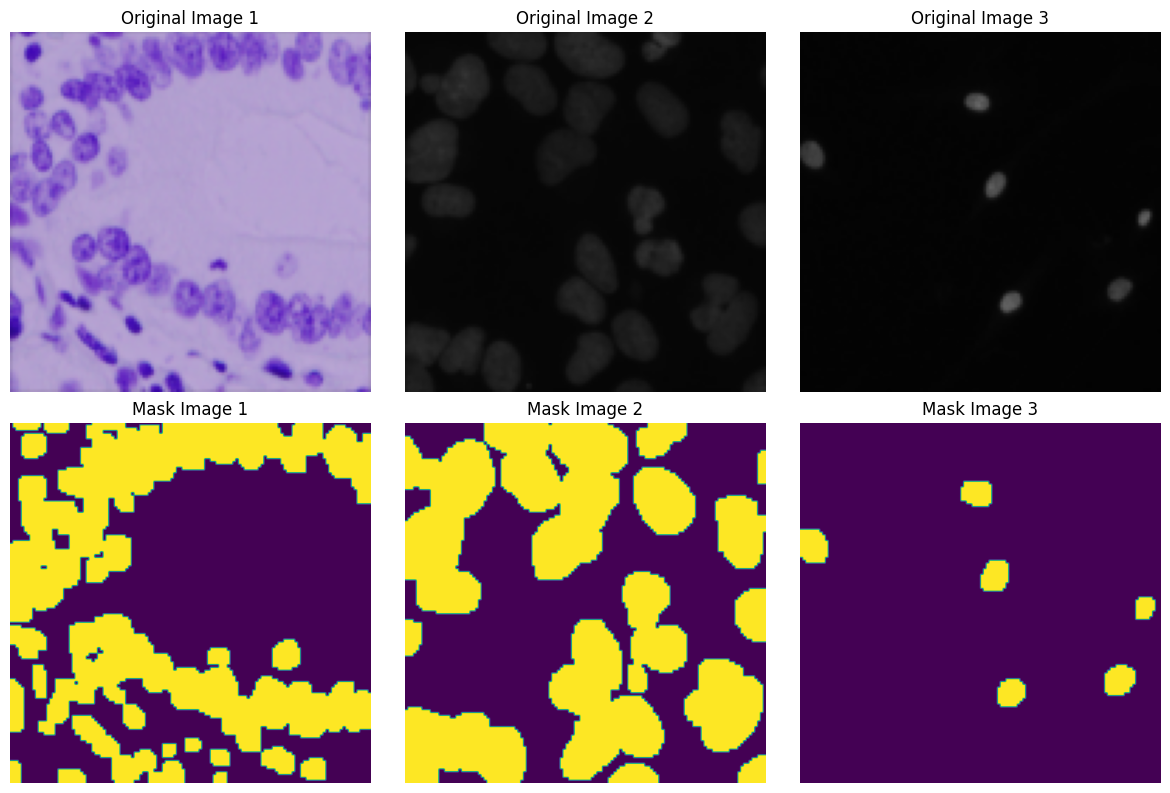

In [10]:
display_sample_grid(X_train, Y_train, num_samples=3)

#**Build U-Net Model:**
U-Net is a convolutional neural network architecture designed for biomedical image segmentation.
It consists of a contracting path (encoder) and an expansive path (decoder) with skip connections.

In [11]:
def convolutional_block(inputs, filters, dropout_rate=0.1):
    """
    Define a convolutional block with two convolutional layers and dropout.

    Parameters:
    - inputs: Input tensor.
    - filters: Number of filters for the convolutional layers.
    - dropout_rate: Dropout rate for regularization.

    Returns:
    - conv: Output tensor of the convolutional block.
    """
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv = tf.keras.layers.Dropout(dropout_rate)(conv)
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    return conv

def build_unet(input_shape, filter_counts=[16, 32, 64, 128, 256], dropout_rates=[0.1, 0.1, 0.2, 0.2, 0.3]):
    """
    Build the U-Net model with specified filters and dropout rates.

    Parameters:
    - input_shape: Shape of the input image.
    - filter_counts: List of filter counts for each convolutional block.
    - dropout_rates: List of dropout rates corresponding to each convolutional block.

    Returns:
    - model: Constructed U-Net model.
    """
    # Input layer
    input_layer = tf.keras.layers.Input(input_shape)
    # Normalize inputs to a range of [0, 1]
    scaled_input = tf.keras.layers.Lambda(lambda x: x / 255)(input_layer)

    # Contraction Path (Encoder):
    # Each block in the contraction path consists of two convolutional layers followed by max pooling
    conv1 = convolutional_block(scaled_input, filter_counts[0], dropout_rates[0])
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = convolutional_block(pool1, filter_counts[1], dropout_rates[1])
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = convolutional_block(pool2, filter_counts[2], dropout_rates[2])
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    conv4 = convolutional_block(pool3, filter_counts[3], dropout_rates[3])
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)

    # Bottleneck layer
    conv5 = convolutional_block(pool4, filter_counts[4], dropout_rates[4])

    # Expansive path (Decoder):
    # Each block in the expansive path consists of an up-convolution followed by concatenation with the corresponding contraction block
    up6 = tf.keras.layers.Conv2DTranspose(filter_counts[3], (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv4])
    conv6 = convolutional_block(up6, filter_counts[3], dropout_rates[3])

    up7 = tf.keras.layers.Conv2DTranspose(filter_counts[2], (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv3])
    conv7 = convolutional_block(up7, filter_counts[2], dropout_rates[2])

    up8 = tf.keras.layers.Conv2DTranspose(filter_counts[1], (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = tf.keras.layers.concatenate([up8, conv2])
    conv8 = convolutional_block(up8, filter_counts[1], dropout_rates[1])

    up9 = tf.keras.layers.Conv2DTranspose(filter_counts[0], (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = tf.keras.layers.concatenate([up9, conv1])
    conv9 = convolutional_block(up9, filter_counts[0], dropout_rates[0])

    # Output layer with a single neuron and sigmoid activation to output a probability map for segmentation
    output_layer = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # Compiling the model
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [12]:
# Create the U-Net model
unet_model = build_unet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Display the structure of the U-Net model
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

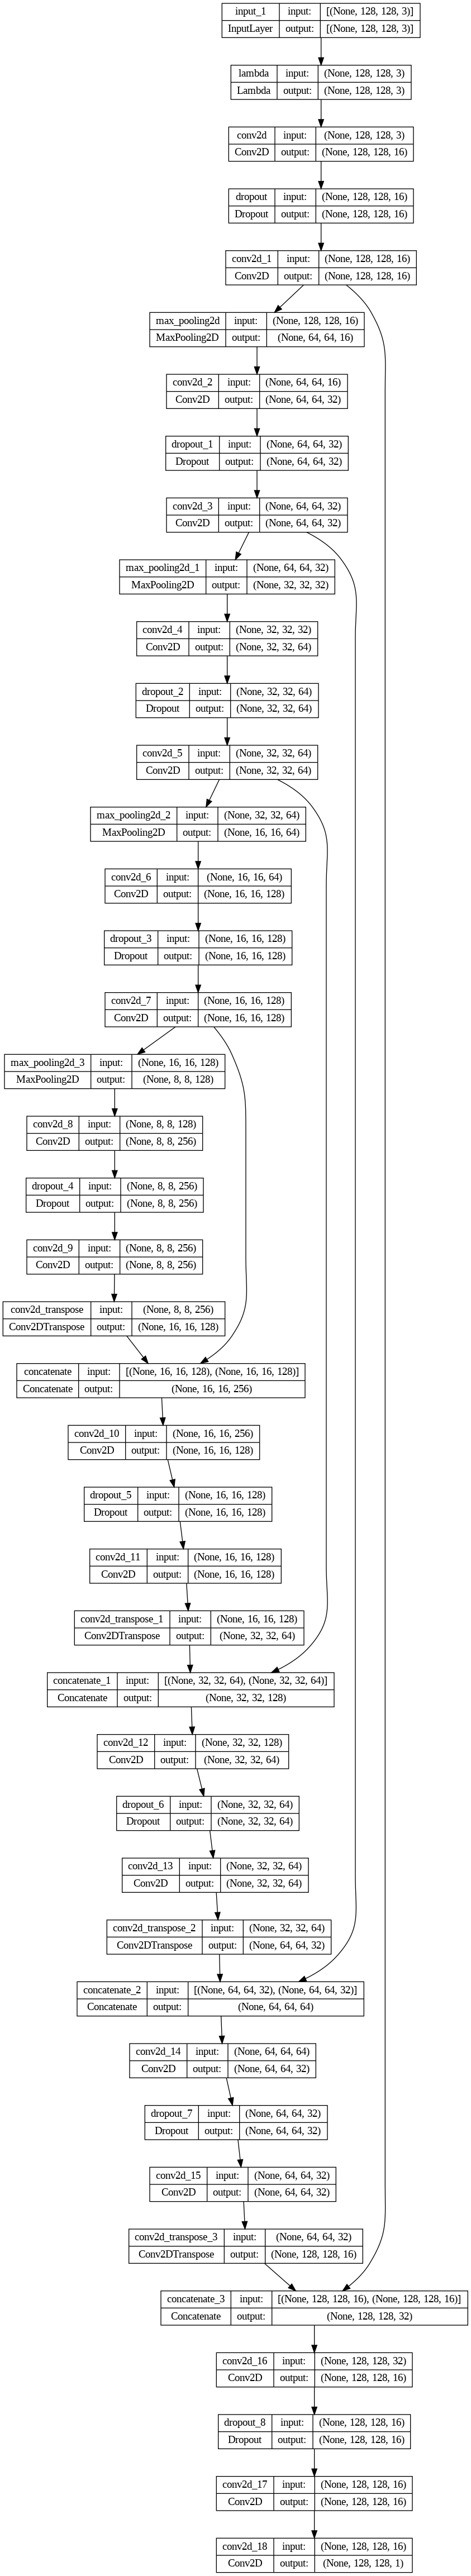

In [13]:
# Generate a plot of the U-Net model's architecture
tf.keras.utils.plot_model(unet_model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

#Define callbacks to have more control during model training

##**Model Checkpoint**
*   Callback to save the model with the best validation loss
*   This ensures that we always save the model in its best-performing state on the validation data




In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_UNet_nuclei.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'    # The target, 'val_loss', should be minimized
)

# Early Stopping


*   Callback to stop training when the validation loss stops improving
*   This helps in preventing overfitting and reduces unnecessary training time



In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min',
    verbose=1
)

# TensorBoard Logging


*   Callback to log training progress for visualization in TensorBoard
*   It provides great visualization tools which help in monitoring the training process



In [16]:
tensorboard_logger = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1       # Log histogram visualizations every 1 epoch
)

# Callbacks List


*   List of callbacks to be used in model training
*   Including model checkpointing, early stopping, and TensorBoard logging

In [17]:
callbacks_list = [model_checkpoint, early_stopping, tensorboard_logger]

# Training the U-Net Model
The model is trained using the training data, is validated on a subset of it, and is monitored and enhanced the training process by the defined callbacks.


In [19]:
results = unet_model.fit(
    x=X_train,
    y=Y_train,
    batch_size=16,
    epochs=25,
    validation_split=0.1,
    callbacks=callbacks_list
)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.7515
Epoch 1: val_loss improved from inf to 0.42451, saving model to model_UNet_nuclei.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 23s 160ms/step - loss: 0.5925 - accuracy: 0.7515 - val_loss: 0.4245 - val_accuracy: 0.7738
Epoch 2/25
37/38 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8430
Epoch 2: val_loss improved from 0.42451 to 0.24065, saving model to model_UNet_nuclei.h5
38/38 [==============================] - 2s 66ms/step - loss: 0.3140 - accuracy: 0.8445 - val_loss: 0.2407 - val_accuracy: 0.8992
Epoch 3/25
37/38 [============================>.] - ETA: 0s - loss: 0.1819 - accuracy: 0.9319
Epoch 3: val_loss improved from 0.24065 to 0.14249, saving model to model_UNet_nuclei.h5
38/38 [==============================] - 3s 66ms/step - loss: 0.1823 - accuracy: 0.9316 - val_loss: 0.1425 - val_accuracy: 0.9464
Epoch 4/25
37/38 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9447
Epoch 4: val_loss improved from 0.14249 to 0.11925, saving model to model_UNet_nuclei.h5
38/38 [==============================] - 2s 65ms/step - los

## Test Data Preparation and Loading

This section is dedicated to preparing and loading the test dataset. It involves locating the test image files, preprocessing them to match the format used during training, and loading them into an array for evaluation.


In [36]:
# Define the path to the test dataset
TEST_PATH = '/content/dsb2018/stage1_test/'

In [37]:
def get_test_data_paths(test_path):
    """
    Retrieve paths to the folders named by IDs in the test set.
    This function navigates through the test data directory and collects the IDs of each test image.
    """
    return next(os.walk(test_path))[1]

In [38]:
def preprocess_test_image(id_, test_path, img_height, img_width, img_channels):
    """
    Preprocess a single test image.
    Reads the image file, resizes it to the required dimensions, and normalizes it.
    Parameters:
    - id_ (str): The unique identifier for each image.
    - test_path (str): Directory path where test images are stored.
    - img_height, img_width, img_channels (int): The dimensions and channels to resize the images.
    Returns:
    - ndarray: The preprocessed image.
    """
    img_file_path = os.path.join(test_path, id_, "images", id_ + ".png")
    img = imread(img_file_path)[:, :, :img_channels]
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    return img

In [39]:
def load_test_dataset(test_path, img_height, img_width, img_channels):
    """
    Load and preprocess the entire test dataset.
    Iterates over each test image, applies preprocessing, and loads them into an array.
    Parameters:
    - test_path (str): Directory path where test images are stored.
    - img_height, img_width, img_channels (int): The dimensions and channels to resize the images.
    Returns:
    - ndarray: Array of all preprocessed test images.
    """
    test_ids = get_test_data_paths(test_path)
    X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
    for n, id_ in enumerate(test_ids):
        X_test[n] = preprocess_test_image(id_, test_path, img_height, img_width, img_channels)
    return X_test

In [40]:
# Load the test dataset for model evaluation
X_test = load_test_dataset(TEST_PATH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

#  Making predictions on the training, validation, and test datasets

In [41]:
def predict_on_datasets(model, X_train, X_test):
    """
    Make predictions on training, validation, and test datasets using the trained model.

    Parameters:
    - model: The trained model to be used for predictions.
    - X_train: Array of training data.
    - X_test: Array of test data.

    Returns:
    - preds_train: Predictions made on the training subset.
    - preds_val: Predictions made on the validation subset.
    - preds_test: Predictions made on the test dataset.
    """
    # Splitting the training data into training and validation sets
    train_val_split = int(X_train.shape[0] * 0.9)

    # Making predictions
    preds_train = model.predict(X_train[:train_val_split], verbose=1)
    preds_val = model.predict(X_train[train_val_split:], verbose=1)
    preds_test = model.predict(X_test, verbose=1)

    return preds_train, preds_val, preds_test

# Execute prediction function
preds_train, preds_val, preds_test = predict_on_datasets(unet_model, X_train, X_test)

3/3 [==============================] - 0s 13ms/step


## Post-Processing Predictions to Create Binary Masks

This section involves post-processing the raw output from the model. The predicted probabilities are converted into binary masks using a defined threshold. This step is essential for transforming the model's continuous predictions into a binary format, suitable for evaluating the model's performance in segmentation tasks.

In [42]:
def threshold_predictions(predictions):
    """
    Apply a threshold to model predictions to create binary masks.

    Parameters:
    - predictions: Array of predicted values from the model.

    Returns:
    - Binary masks after applying threshold.
    """
    # Applying a threshold of 0.5 to convert probabilities to binary values (0 or 1)
    return (predictions > 0.5).astype(np.uint8)

# Apply threshold to convert model predictions to binary masks
preds_train_t = threshold_predictions(preds_train)
preds_val_t = threshold_predictions(preds_val)
preds_test_t = threshold_predictions(preds_test)

## Visualization of Model Predictions

This section is focused on visualizing the model's performance. For a randomly selected sample from the dataset, the original image, the ground truth mask, and the predicted mask are displayed.


Random Training Sample:


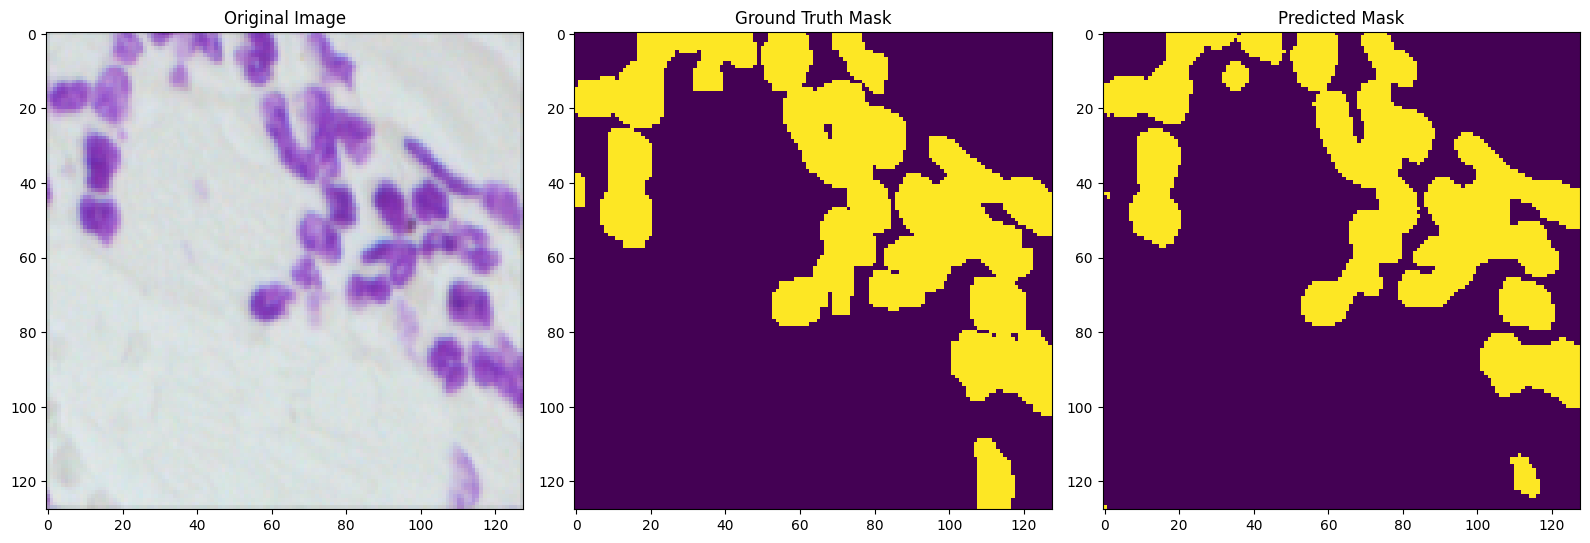

In [56]:
def display_random_sample(X_data, Y_data, predictions):
    """
    Display a random sample consisting of the original image, ground truth mask, and predicted mask.

    Parameters:
    - X_data: Array of original images.
    - Y_data: Array of ground truth masks.
    - predictions: Array of predicted masks by the model.

    The function randomly selects an image from the dataset, displays the original image,
    the actual mask (ground truth), and the mask predicted by the model. This visual comparison
    helps in understanding the model's segmentation accuracy on a qualitative level.
    """
    # Randomly select an index from the dataset
    ix = random.randint(0, len(predictions) - 1)

    # Plot original image, ground truth mask, and predicted mask
    fig, ax = plt.subplots(1, 3, figsize=(16, 8))
    ax[0].imshow(X_data[ix])
    ax[0].title.set_text('Original Image')

    ax[1].imshow(np.squeeze(Y_data[ix]))
    ax[1].title.set_text('Ground Truth Mask')

    ax[2].imshow(np.squeeze(predictions[ix]))
    ax[2].title.set_text('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Display random training sample
print("Random Training Sample:")
display_random_sample(X_train, Y_train, preds_train_t)

## Model Training History Analysis

This section focuses on extracting and analyzing the training history of the model. The key metrics like loss and accuracy for both the training and validation sets are reviewed.


In [59]:
# Extracting loss values for training and validation sets
loss = results.history['loss']                      # Training loss
val_loss = results.history['val_loss']              # Validation loss

# Extracting accuracy values for training and validation sets
accuracy = results.history.get('accuracy')          # Training accuracy
val_accuracy = results.history.get('val_accuracy')  # Validation accuracy

In [60]:
print("Training Loss: ", loss[-1])
print("Validation Loss: ", val_loss[-1])
print("Training Accuracy: ", accuracy[-1])
print("Validation Accuracy: ", val_accuracy[-1])

Training Loss:  0.08771512657403946
Validation Loss:  0.07943518459796906
Training Accuracy:  0.965362012386322
Validation Accuracy:  0.9692874550819397


## Visualization of Training and Validation Metrics



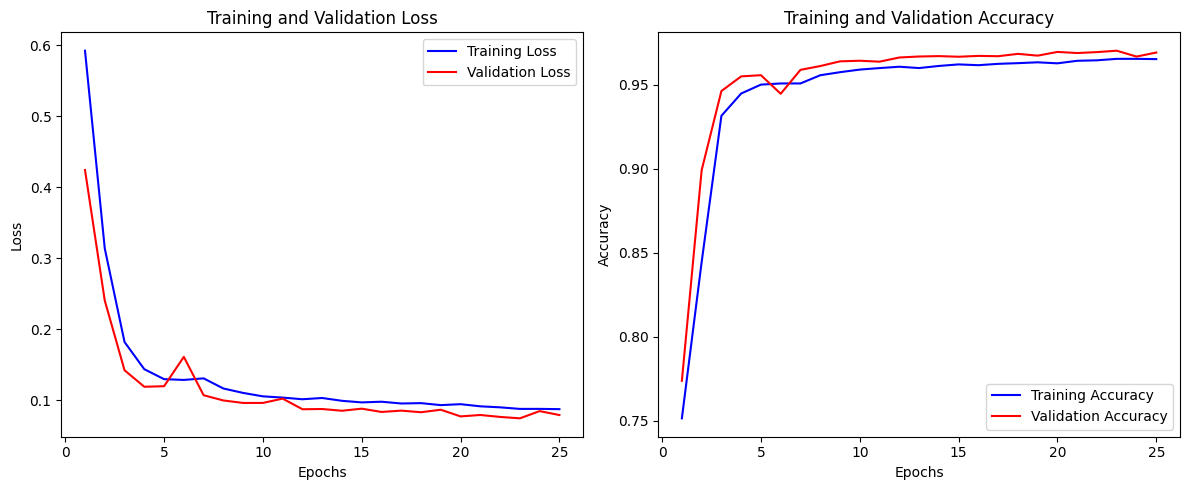

In [61]:
# Number of epochs - determines the X-axis in the plots
epochs = range(1, len(loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values (if available)
if accuracy is not None and val_accuracy is not None:
    # Subplot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()